In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import afterglowpy as grb

In [2]:
def loadDataFromFile(filename):
    """
    Load GRB afterglow data from a .txt file.
    
    Arguments
    
        filename: the name (and path) to the data file.
        
    Returns
        
        t: array
            observed times in seconds
        nu: array
            observed frequency in Hz
        Fnu: array
            observed flux in mJy
        Ferr: array
            uncertainty in observed flux in mJy
    """
    
    
    t_all, nu_all, Fnu_all, Ferr_all, ul_all = np.loadtxt(filename, usecols=[0,1,2,3,4], unpack=True)
    
    detections = (ul_all == 0.0)
    t_det = t_all[detections]
    nu_det = nu_all[detections]
    Fnu_det = Fnu_all[detections]
    Ferr_det = Ferr_all[detections]
    
    return t_det, nu_det, Fnu_det, Ferr_det
    

In [3]:
# Load the data!

t_data, nu_data, Fnu_data, Ferr_data = loadDataFromFile("../data/180720B_data.txt")

In [4]:
print(nu_data)

[1.20899462e+18 1.20899462e+18 1.20899462e+18 1.20899462e+18
 1.20899462e+18 1.20899462e+18 1.20899462e+18 1.20899462e+18
 1.20899462e+18 1.20899462e+18 1.20899462e+18 1.20899462e+18
 1.20899462e+18 1.20899462e+18 1.20899462e+18 1.20899462e+18
 1.20899462e+18 1.20899462e+18 1.20899462e+18 1.20899462e+18
 1.20899462e+18 1.20899462e+18 1.20899462e+18 1.20899462e+18
 1.20899462e+18 1.55000000e+10 1.55000000e+10 1.55000000e+10
 4.67706708e+14 4.67706708e+14 4.67706708e+14 4.67706708e+14
 4.67706708e+14 4.67706708e+14 4.67706708e+14 4.67706708e+14
 4.67706708e+14 4.67706708e+14 4.67706708e+14 4.67706708e+14
 4.67706708e+14 4.67706708e+14 4.67706708e+14 4.67706708e+14
 4.67706708e+14 1.40000000e+09]


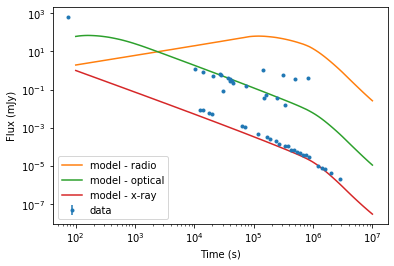

Text(0, 0.5, 'flux $F_\\nu$ (mJy)')

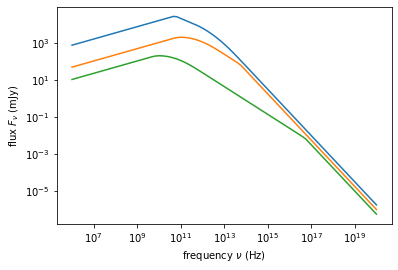

In [39]:
# Times and Frequencies for the model
t = np.geomspace(1.0e2, 1.0e7, 100)

nuR = np.empty(t.shape)
nuR[:] = 1.5e10

nuO = np.empty(t.shape)
nuO[:] = 4.67706708e+14

nuX = np.empty(t.shape)
nuX[:] = 1.2e18

# Parameters for the model
Z = {'jetType': grb.jet.TopHat,  # type of jet structure
     'specType': 0,              # type of spectrum
     'thetaObs': 0.0,   # observer angle (radians)
     'E0': 1.0e55,      # isotropic energy (erg)
     'thetaCore': 0.25, # jet opening angle (radians)
     'n0': 150.0,         # ambient ISM density (cm^{-3})
     'p': 2.5,          # electron energy slope (no units)
     'epsilon_e': 0.1,  # fraction of energy in accelerated electrons (no units)
     'epsilon_B': 0.0000001, # fraction of energy in magnetic field (no units)
     'ksiN': 1.0,       # fraction of electrons that get accelerated (no units)
     'dL': 1.21e28,     # luminosity distance (cm)
     'z': 0.654         # redshift (no units)
    } 

# Calculate the model!
FnuR = grb.fluxDensity(t, nuR, **Z)  # the model, theoretical prediction
FnuO = grb.fluxDensity(t, nuO, **Z)  # the model, theoretical prediction
FnuX = grb.fluxDensity(t, nuX, **Z)  # the model, theoretical prediction

# Plot the data
plt.errorbar(t_data, Fnu_data, Ferr_data, ls='', marker='.', label='data')

# Plot the model
plt.plot(t, FnuR, label='model - radio')
plt.plot(t, FnuO, label='model - optical')
plt.plot(t, FnuX, label='model - x-ray')

# Scale the Axes
plt.xscale('log')
plt.yscale('log')

# Add a legend
plt.legend()

# Add some labels
plt.xlabel('Time (s)')
plt.ylabel('Flux (mJy)')
plt.show()


nu_spec = np.geomspace(1.0e6, 1.0e20, 100)
t_spec = np.empty(nu_spec.shape)
t_spec[:] = 3.0e5

Z['epsilon_B'] = 0.01
Fnu_spec1 = grb.fluxDensity(t_spec, nu_spec, **Z)

Z['epsilon_B'] = 0.0001
Fnu_spec2 = grb.fluxDensity(t_spec, nu_spec, **Z)

Z['epsilon_B'] = 0.000001
Fnu_spec3 = grb.fluxDensity(t_spec, nu_spec, **Z)


plt.loglog(nu_spec, Fnu_spec1)
plt.loglog(nu_spec, Fnu_spec2)
plt.loglog(nu_spec, Fnu_spec3)
plt.xlabel(r'frequency $\nu$ (Hz)')
plt.ylabel(r'flux $F_\nu$ (mJy)')

In [58]:
def fit_function(xdata, E0, thetaCore, n0, p):
    """
    Assumes xdata = {'t_data': t_data, 'nu_data': nu_data, 'Z': Z}
    """
    t_data = xdata['t_data']
    nu_data = xdata['nu_data']
    Z = xdata['Z']
    
    Z['E0'] = E0
    Z['thetaCore'] = thetaCore
    Z['n0'] = n0
    Z['p'] = p
    
    # print(E0, thetaCore, n0, p)
    
    Fnu = grb.fluxDensity(t_data, nu_data, **Z)
    
    return Fnu

def chi2_function(Fnu_model, Fnu_data, Ferr_data):
    
    residual = (Fnu_model - Fnu_data) / Ferr_data
    
    return np.sum( residual**2 )

In [59]:
# Parameters for the model
Zguess = {'jetType': grb.jet.TopHat,  # type of jet structure
          'specType': 0,              # type of spectrum
          'thetaObs': 0.0,   # observer angle (radians)
          'E0': 1.0e54,      # isotropic energy (erg)
          'thetaCore': 0.1, # jet opening angle (radians)
          'n0': 1.0,         # ambient ISM density (cm^{-3})
          'p': 2.5,          # electron energy slope (no units)
          'epsilon_e': 0.1,  # fraction of energy in accelerated electrons (no units)
          'epsilon_B': 0.0001, # fraction of energy in magnetic field (no units)
          'ksiN': 1.0,       # fraction of electrons that get accelerated (no units)
          'dL': 1.21e28,     # luminosity distance (cm)
          'z': 0.654         # redshift (no units)
         } 
# Load the data!
t_data, nu_data, Fnu_data, Ferr_data = loadDataFromFile("../data/180720B_data.txt")

#Package fixed data
xdata = {'t_data': t_data,
         'nu_data': nu_data,
         'Z': Zguess}

#Compute model with guess values
Fnu_model = fit_function(xdata, 1.0e53, 0.1, 1.0, 2.5)

#compute chi2 of guess
print(chi2_function(Fnu_model, Fnu_data, Ferr_data))

89484.99538707187


[1.0e+53 2.5e-01 1.0e+00 2.5e+00]
[[ 1.94594653e-105  1.64037071e-053  8.78660228e-053 -3.86490795e-053]
 [ 1.64037071e-053  4.66000345e+000  1.10223652e-001 -1.96064324e+000]
 [ 8.78660228e-053  1.10223652e-001  4.05535904e+000 -1.51459879e+000]
 [-3.86490795e-053 -1.96064324e+000 -1.51459879e+000  2.12110197e+000]]
90296.9015848914


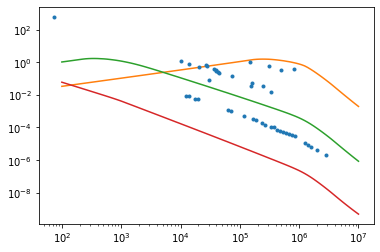

In [61]:
# Try a fit!
#.        E0.    thetaCore density  p 
guess = [1.0e53, 0.25,      1.0,     2.5]

# Set bounds
lower_bounds = np.array([1.0e48, 0.0,     1.0e-5, 2.0])
upper_bounds = np.array([1.0e56, np.pi/2, 1.0e5,  3.0])
bounds = (lower_bounds, upper_bounds)

popt, pcov = scipy.optimize.curve_fit(fit_function, xdata, Fnu_data, sigma=Ferr_data,
                                      p0=guess, bounds=bounds)

print(popt)
print(pcov)

#Compute model with guess values
Fnu_model = fit_function(xdata, *popt)

#Compute chi2 of guess
print(chi2_function(Fnu_model, Fnu_data, Ferr_data))

xdataR = {'t_data': t,
         'nu_data': nuR,
         'Z': Zguess}
xdataO = {'t_data': t,
         'nu_data': nuO,
         'Z': Zguess}
xdataX = {'t_data': t,
         'nu_data': nuX,
         'Z': Zguess}

# Calculate the model!
FnuR = fit_function(xdataR, *popt)
FnuO = fit_function(xdataO, *popt)
FnuX = fit_function(xdataX, *popt)

# Plot the data
plt.errorbar(t_data, Fnu_data, Ferr_data, ls='', marker='.', label='data')

# Plot the model
plt.plot(t, FnuR, label='model - radio')
plt.plot(t, FnuO, label='model - optical')
plt.plot(t, FnuX, label='model - x-ray')

plt.xscale('log')
plt.yscale('log')

plt.show()